In [51]:
import os
import numpy as np
import ipynb
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine
from scipy.stats import levene, wilcoxon, ttest_rel, ttest_ind
from cliffs_delta import cliffs_delta
from ipynb.fs.defs.functions_and_classes import *

In [52]:
#model = 'word2vec'
model = 'glove'
#model = 'fasttext'
dim = 300
#language = 'he'
language = 'en'
#suffix_pair = ['ity', 'ness']
suffix_pair = ['al', 'less']
suff1, suff2 = suffix_pair

In [53]:
fname = f'{model}_{dim}_{language}_vectors_reduced.txt'
embedding = build_dict_from_vector_file('./models/reduced/', fname)
if language == 'he':
    path_to_dataset = './datasets/he/definitive_dataset.csv'
if language == 'en':
    path_to_dataset = f'./datasets/en/{suff1}_{suff2}_dataset_filtered.csv'
dataset = load_dataset_from_csv(language, path_to_dataset)
dataset.filter_against_embedding(embedding)

Processed 0
Embedding entries: 176
Embedding dimension: 96
Number of datapoints before adjustment: 205
Number of datapoints after adjustment: 59


In [54]:
triplets = dataset.get_triplets()
print(triplets)

[['accent', 'accentual', 'accentless'], ['action', 'actional', 'actionless'], ['author', 'authorial', 'authorless'], ['bride', 'bridal', 'brideless'], ['case', 'casual', 'caseless'], ['cause', 'causal', 'causeless'], ['cement', 'cemental', 'cementless'], ['center', 'central', 'centerless'], ['client', 'cliental', 'clientless'], ['crust', 'crustal', 'crustless'], ['dimension', 'dimensional', 'dimensionless'], ['direction', 'directional', 'directionless'], ['disk', 'discal', 'diskless'], ['distortion', 'distortional', 'distortionless'], ['duration', 'durational', 'durationless'], ['emotion', 'emotional', 'emotionless'], ['event', 'eventual', 'eventless'], ['exception', 'exceptional', 'exceptionless'], ['expression', 'expressional', 'expressionless'], ['face', 'facial', 'faceless'], ['feature', 'featural', 'featureless'], ['form', 'formal', 'formless'], ['foundation', 'foundational', 'foundationless'], ['friction', 'frictional', 'frictionless'], ['front', 'frontal', 'frontless'], ['functi

In [55]:
def compute_similarities(embedding, triplets, mode='mean', ref='noun'):
    """ If ref is 'noun', we collect noun/denominal and noun/other verb sims;
    if ref is 'denominal' we collect denominal/noun and denominal/other verb sims."""

    sims_n_dn = []
    sims_ref_ndn = []
    best_ndns = []
    for triplet in triplets:
        print(triplet)
        n = triplet[0]
        dn = triplet[1]
        ndns = triplet[2] #DO WE ALSO CONSIDER THE OTHER ROOT DERIVED ELEMENTS????
        
        sim_n_dn = 1 - cosine(embedding[n], embedding[dn])
        sims_n_dn.append(sim_n_dn)
        
        
        if ref =='noun':
            reference = n
        if ref == 'denominal':
            reference = dn
            
        if mode == 'best':
            index_best_ndn = np.argmax([1 - cosine(embedding[reference], embedding[ndn]) for ndn in ndns])
            best_ndn = ndns[index_best_ndn]
            best_ndn_vec = embedding[best_ndn]
            best_ndns.append(best_ndn)
            sim_ref_ndn = 1 - cosine(embedding[reference], best_ndn_vec)

        if mode == 'mean':
            #other_vec = np.mean([embedding[other_verb] for other_verb in other_verbs], axis=0)
            sim_ref_ndn = np.mean([1 - cosine(embedding[reference], embedding[ndn]) for ndn in ndns], axis=0)

        sims_ref_ndn.append(sim_ref_ndn)

    return (sims_n_dn, sims_ref_ndn, best_ndns)

In [56]:
if language == 'he':
    sims_n_dn, sims_ref_ndn, best_ndns = compute_similarities(embedding, triplets, mode=mode, ref=ref)

In [57]:
def test_diff(sims_n_dn, sims_ref_ndn):
    diff_sims_dn_ndn = np.array(sims_n_dn) - np.array(sims_ref_ndn)
    print(f'Sample size: {len(diff_sims_dn_ndn)}')
    plt.hist(diff_sims_dn_ndn)
    plt.show()

    std = np.std(diff_sims_dn_ndn)
    mean = np.mean(diff_sims_dn_ndn)
    outp = [mean, std]
    print(f'Standard deviation: {std}')
    print(f'Mean: {mean}')

    _, p = levene(sims_n_dn, sims_ref_ndn)
    print(f'Levene p: {p}')

    if p > .05:
        print("F-test failed, performing Wilcoxon")
        outp.append('w')
        _, p = wilcoxon(sims_n_dn, sims_ref_ndn, zero_method='wilcox', correction=False, alternative='greater')
    else:
        print("F-test succeeded, performing t-test")
        outp.append('t')
        _, p = ttest_rel(sims_n_dn, sims_ref_ndn, alternative='greater')
        
    d, res = cliffs_delta(sims_n_dn, sims_ref_ndn)
    
    print(f'P-value: {p}')
    print(f'Effect size (Cliff\'s delta): {d} ({res})')
    outp.extend([p, d, res])

    return diff_sims_dn_ndn, outp


In [58]:
if language == 'he':
    diff_sims_dn_ndn, outp = test_diff(sims_n_dn, sims_ref_ndn)

In [59]:
def save_report(model, dim, language, mode, ref, outp):
    mean, std, test, p, d, res = outp
    fname = f'{model}_{dim}_{language}_{mode}_{ref}_report.txt'
    with open(f'./reports/{fname}', 'w') as f:
        f.write(f'Mean: {mean}\n')
        f.write(f'Std: {std}\n')
        f.write(f'Test: {test}\n')
        f.write(f'P-value: {p}\n')
        f.write(f"Cliff' s delta': {d}\n")
        f.write(f'Effect: {res}\n')


In [60]:
if language == 'he':
    save_report(model, dim, language, mode, ref, outp)

In [61]:
from ipynb.fs.defs.visualization import *  
len(triplets)

59

In [62]:
suff1_vecs, suff2_vecs = compute_affixal_vecs(embedding, triplets)

In [71]:
def intra_group_sims(vecs):
    sims = []
    for v1 in vecs:
        for v2 in vecs:
            if not np.array_equal(v1, v2):
                s = 1 - cosine(v1, v2)
                sims.append(s)
    return sims
            

In [72]:
def test_intra_group_sim_diff(suff1_vecs, suff2_vecs):
    sims_suff1 = intra_group_sims(suff1_vecs)
    sims_suff2 = intra_group_sims(suff2_vecs)
    plt.hist(sims_suff1, alpha=.5, label=suff1)
    plt.hist(sims_suff2, alpha=.5, label=suff2)
    plt.legend()
    _, p = ttest_ind(sims_suff2, sims_suff1, alternative='greater')
    print(p)

2.010357680649311e-86


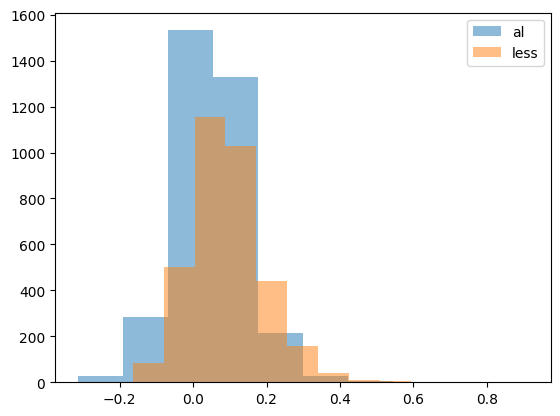

In [73]:
test_intra_group_sim_diff(suff1_vecs, suff2_vecs)

list